In [208]:
import sys
sys.path.append("..")
from architecture import VGG16_BN

import torch
import numpy as np
import matplotlib.pyplot as plt

In [209]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [210]:
# load best model's parameter
model = VGG16_BN()
checkpoint = torch.load('./vgg16_baseline_exp3/checkpoint/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [211]:
for param in model.parameters() :
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

# what is the convnet filter? (check the architecture)
![](./vgg16_architecture.png)

# #Maps, #Params, #FLOPs function definition

* FLOP operator reference : https://pypi.org/project/flopth/
* `usage` : 
   * file path : /tmp/my_model.py
   * model name : MyModel
     * `command` : **flopth -m MyModel -p /tmp/my_model -i 3 224 224**

In [212]:
def numMapsParams(_model) :
    # the number of maps
    num_maps = []
    num_params = []
    for param in _model.parameters() :
        # conv layer weight's the number of maps, the number of params
        if len(param.shape) == 4 : 
            num_maps.append(param.shape[0])
            num_params.append(param.shape[0] * param.shape[1] * param.shape[2] * param.shape[3])
        # fc layer weight's the number of maps
        elif len(param.shape) == 2 :
            num_maps.append(param.shape[0])
            num_params.append(param.shape[0] * param.shape[1])
                
            
    return num_maps, num_params 

# #Maps, #Params, #FLOPs before pruning
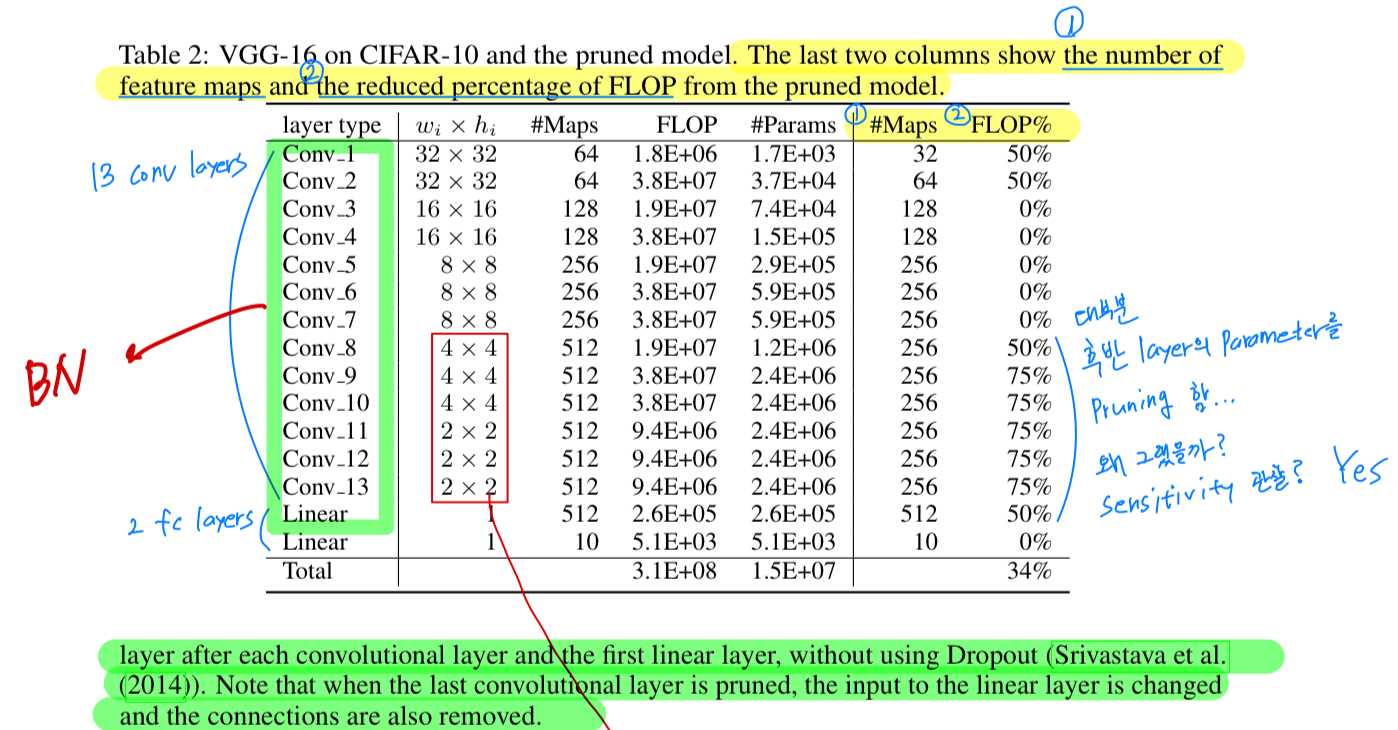

In [213]:
before_num_maps, before_num_params = numMapsParams(model)
before_num_params = [f"{formatted:.1e}" for formatted in before_num_params]

print(f"the number of maps before pruning : {before_num_maps}")
print(f"the number of params before pruning : {before_num_params}")

the number of maps before pruning : [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 10]
the number of params before pruning : ['1.7e+03', '3.7e+04', '7.4e+04', '1.5e+05', '2.9e+05', '5.9e+05', '5.9e+05', '1.2e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.4e+06', '2.6e+05', '5.1e+03']


In [214]:
print("the number of flops before pruning")
! flopth -m VGG16_BN -p ./architecture -i 3 32 32

the number of flops before pruning


Op Flatten is not supported at now, set FLOPs of it to zero.
+----------------+---------------+-------------+-------------+------------------------------+----------+------------------+----------------------+----------+-----------------+---------------------+
| module_name    | module_type   | in_shape    | out_shape   | kernel_size,padding,stride   | params   | params_percent   | params_percent_vis   | flops    | flops_percent   | flops_percent_vis   |
+================+===============+=============+=============+==============================+==========+==================+======================+==========+=================+=====================+
| conv_layers.0  | Conv2d        | (3,32,32)   | (64,32,32)  | k=(3, 3), p=(1, 1), s=(1, 1) | 1.792K   | 0.0119531%       |                      | 1.83501M | 0.583105%       |                     |
+----------------+---------------+-------------+-------------+------------------------------+----------+------------------+----------------------+-

## Figure 2: (a) Sorting filters by absolute weights sum for each layer of VGG-16 on CIFAR-10

In [215]:
# count the number of conv layer in the model
def countConvLayers(_model) :
    num_conv_layers = 0
    for layer in _model.modules() :
        if isinstance(layer, torch.nn.Conv2d) :
            num_conv_layers += 1
    return num_conv_layers

num_conv_layers = countConvLayers(model)
print(f"the number of conv layers : {num_conv_layers}")

the number of conv layers : 13


In [216]:
def sortingFilterByAbsWeightSumForEachLayer(_weight) :
    # L1 norm of each filter
    s_j = torch.sum(torch.abs(_weight), dim=(1, 2, 3))
    # sorting by s_j in descending order
    sorted_filter_idx_list = torch.sort(s_j, descending=True)
    # sorting _weight by sorted_filter_idx_list
    _weight = _weight[sorted_filter_idx_list.indices]
    return _weight, sorted_filter_idx_list

In [217]:
sorted_weight_list = []     
sorted_weight_sj_list = []
sorted_weight_idx_list = []  

idx = 1
for weight in model.parameters() :
    # if conv layer
    if len(weight.shape) == 4 :
        print(f"conv{idx}", end="-"*30+"\n")
        sorted_weight, sorted_weight_idx = sortingFilterByAbsWeightSumForEachLayer(weight)
        sorted_weight_sj_list.append(sorted_weight_idx.values)
        sorted_weight_idx_list.append(sorted_weight_idx.indices)
        sorted_weight_list.append(sorted_weight)
        print(f"sorted_weight.shape : {sorted_weight.shape}")
        print(f"sorted weight's L1 norm : {sorted_weight_idx.values.shape}")
        idx += 1

conv1------------------------------
sorted_weight.shape : torch.Size([64, 3, 3, 3])
sorted weight's L1 norm : torch.Size([64])
conv2------------------------------
sorted_weight.shape : torch.Size([64, 64, 3, 3])
sorted weight's L1 norm : torch.Size([64])
conv3------------------------------
sorted_weight.shape : torch.Size([128, 64, 3, 3])
sorted weight's L1 norm : torch.Size([128])
conv4------------------------------
sorted_weight.shape : torch.Size([128, 128, 3, 3])
sorted weight's L1 norm : torch.Size([128])
conv5------------------------------
sorted_weight.shape : torch.Size([256, 128, 3, 3])
sorted weight's L1 norm : torch.Size([256])
conv6------------------------------
sorted_weight.shape : torch.Size([256, 256, 3, 3])
sorted weight's L1 norm : torch.Size([256])
conv7------------------------------
sorted_weight.shape : torch.Size([256, 256, 3, 3])
sorted weight's L1 norm : torch.Size([256])
conv8------------------------------
sorted_weight.shape : torch.Size([512, 256, 3, 3])
sort

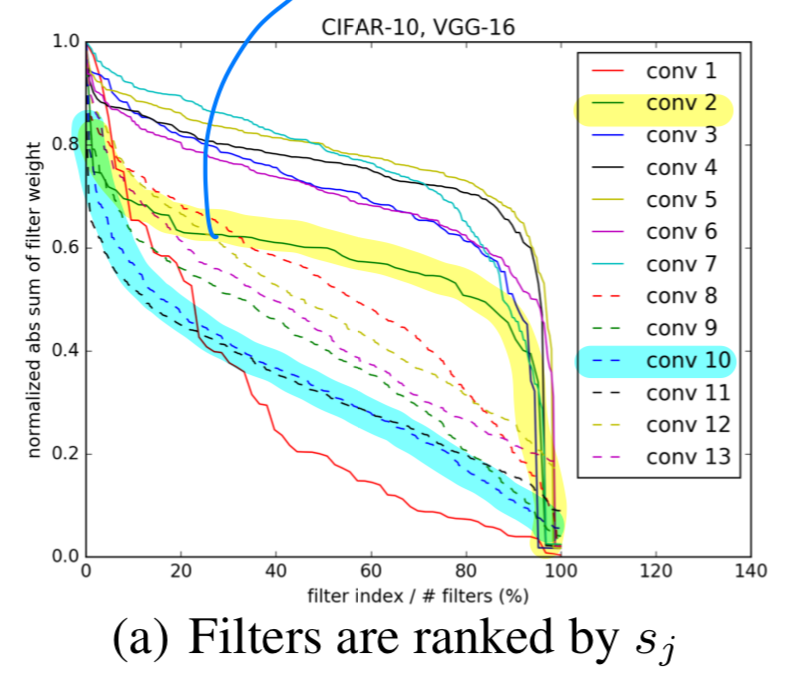

conv1 : 64
conv2 : 64
conv3 : 128
conv4 : 128
conv5 : 256
conv6 : 256
conv7 : 256
conv8 : 512
conv9 : 512
conv10 : 512
conv11 : 512
conv12 : 512
conv13 : 512


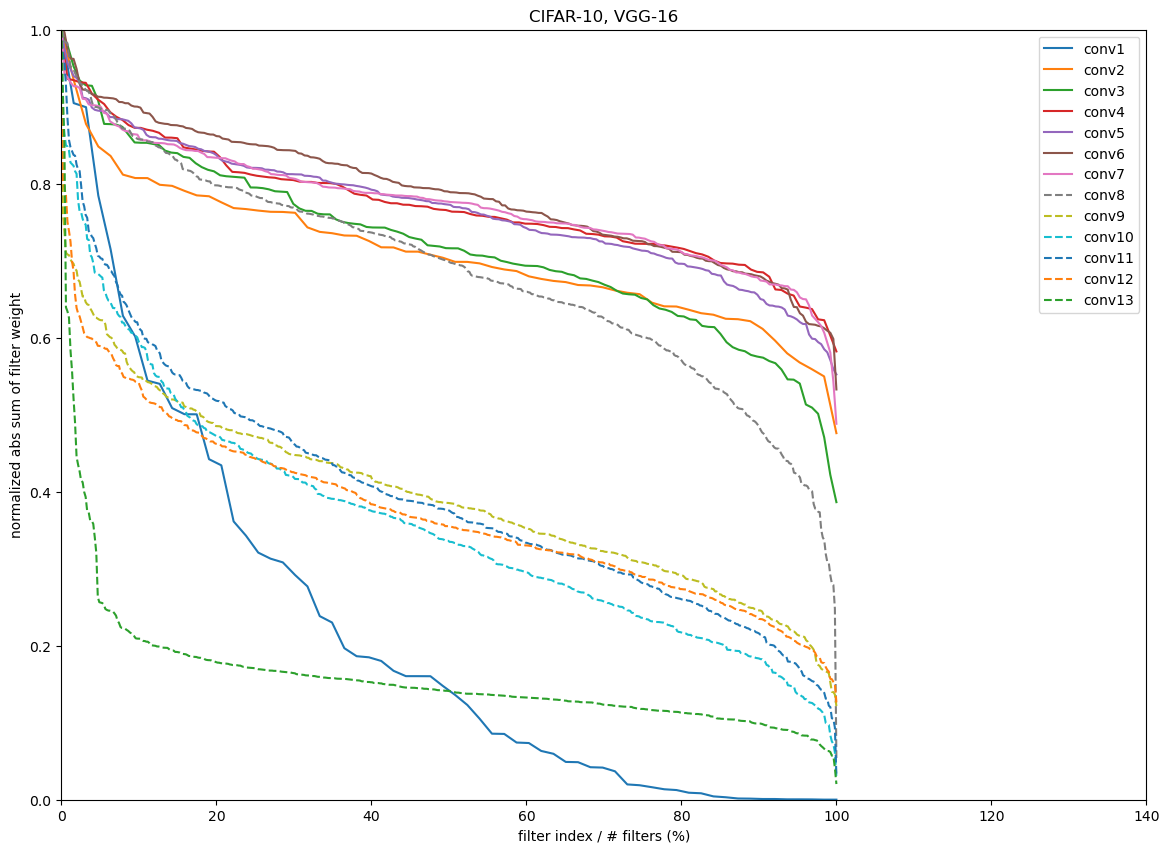

In [221]:
# The y-axis is the filter weight sum divided by the max sum value among filters in that layer. 
normalized_sorted_weight_sj_list = []
for weight_sj in sorted_weight_sj_list :
    weight_sj = weight_sj / torch.max(weight_sj)
    normalized_sorted_weight_sj_list.append(weight_sj.detach().cpu().numpy())
    
# visualization
plt.figure(figsize=(14, 10))
plt.title("CIFAR-10, VGG-16")
plt.xlabel("filter index / # filters (%)")
plt.ylabel("normalized abs sum of filter weight")
plt.xlim([0, 140])
plt.ylim([0, 1])

x_data = []
# set x data (filter index / # filters (%))
for i in range(num_conv_layers) :
    print(f"conv{i+1} : {sorted_weight_sj_list[i].shape[0]}")
    x_data.append(sorted_weight_sj_list[i].shape[0])
# convert 0~100%
plt.plot(np.linspace(0, 100, x_data[0]), normalized_sorted_weight_sj_list[0], label="conv1")
plt.plot(np.linspace(0, 100, x_data[1]) ,normalized_sorted_weight_sj_list[1], label="conv2")
plt.plot(np.linspace(0, 100, x_data[2]) ,normalized_sorted_weight_sj_list[2], label="conv3")
plt.plot(np.linspace(0, 100, x_data[3]) ,normalized_sorted_weight_sj_list[3], label="conv4")
plt.plot(np.linspace(0, 100, x_data[4]) ,normalized_sorted_weight_sj_list[4], label="conv5")
plt.plot(np.linspace(0, 100, x_data[5]) ,normalized_sorted_weight_sj_list[5], label="conv6")
plt.plot(np.linspace(0, 100, x_data[6]) ,normalized_sorted_weight_sj_list[6], label="conv7")
plt.plot(np.linspace(0, 100, x_data[7]) ,normalized_sorted_weight_sj_list[7], label="conv8", linestyle='--')
plt.plot(np.linspace(0, 100, x_data[8]) ,normalized_sorted_weight_sj_list[8], label="conv9", linestyle='--')
plt.plot(np.linspace(0, 100, x_data[9]) ,normalized_sorted_weight_sj_list[9], label="conv10", linestyle='--')
plt.plot(np.linspace(0, 100, x_data[10])  ,normalized_sorted_weight_sj_list[10], label="conv11", linestyle='--')
plt.plot(np.linspace(0, 100, x_data[11])  ,normalized_sorted_weight_sj_list[11], label="conv12", linestyle='--')
plt.plot(np.linspace(0, 100, x_data[12])  ,normalized_sorted_weight_sj_list[12], label="conv13", linestyle='--')
plt.legend()

# save figure
plt.savefig("./Figure_2/a.png")

# #Maps, #Params, #FLOPs after pruning